# Test BWA-MEM `-T` (min alignment score) option

2023-05-16

Vary `-T` (min alignment score) option from 10 to 30, check # discordant reads

In [3]:
from subprocess import Popen, PIPE, DEVNULL
from pathlib import Path
import pandas as pd
import seaborn as sns

In [4]:
def bwamem(r1_fn, r2_fn, ref_fn, outprefix, min_as=30, threads=8):
    """
    1. Map fastq file to reference with bwa mem
    2. Count discordant and clipped reads with samblaster
    """

    # run bwa mem
    bwa_cmd = f"bwa mem -t {threads} -T {min_as} {ref_fn} {r1_fn} {r2_fn} | samblaster -r -d {outprefix}.disc.bam -u {outprefix}.unclip.bam -s {outprefix}.split.bam -o {outprefix}.out.bam"
    Popen(bwa_cmd, shell=True, stdout=DEVNULL, stderr=DEVNULL).communicate()

    for i in ["disc", "unclip", "split", "out"]:
        cmd = f"samtools sort {outprefix}.{i}.bam -o {outprefix}.{i}.sorted.bam"
        Popen(cmd, shell=True, stdout=DEVNULL, stderr=DEVNULL).communicate()
        cmd = f"samtools index {outprefix}.{i}.sorted.bam"
        Popen(cmd, shell=True, stdout=DEVNULL, stderr=DEVNULL).communicate()


def metrics(inprefix, knrgl_fn, extra=""):
    """
    collect alignment metrics from bam files
    """

    # collect metrics
    cmd_prefix = "samtools view -c -F 256"  # count primary alignments
    cmds = {
        "total": f"{cmd_prefix} {extra} {inprefix}.out.sorted.bam",
        "primary_proper_pairs": f"{cmd_prefix} {extra} -f 2 {inprefix}.out.sorted.bam",
        "discordant_r1": f"{cmd_prefix} {extra} -f 64 {inprefix}.disc.sorted.bam",
        "discordant_r2": f"{cmd_prefix} {extra} -f 128 {inprefix}.disc.sorted.bam",
        "split_r1": f"{cmd_prefix} {extra} -f 64 {inprefix}.split.sorted.bam",
        "split_r2": f"{cmd_prefix} {extra} -f 128 {inprefix}.split.sorted.bam",
        "unmapped_clipped_r1": f"{cmd_prefix} {extra} -f 64 {inprefix}.unclip.sorted.bam",
        "unmapped_clipped_r2": f"{cmd_prefix} {extra} -f 128 {inprefix}.unclip.sorted.bam",
    }

    metrics = {}
    for k, v in cmds.items():
        metrics[k] = int(
            Popen(v, shell=True, stdout=PIPE).communicate()[0].decode("utf-8")
        )

        if "unmapped" in k:
            continue
        cmd = v + f" --regions-file {knrgl_fn}"
        metrics[f"{k}_knrgl"] = int(
            Popen(cmd, shell=True, stdout=PIPE).communicate()[0].decode("utf-8")
        )

    return metrics

In [5]:
# define input files
r1 = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/results/fastq/8/USD8_A1_S1_R1.filtered.fastq.gz"
r2 = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/results/fastq/8/USD8_A1_S1_R2.filtered.fastq.gz"
ref = "/iblm/netapp/data4/mcuoco/sz_slavseq/resources/hs38d1.fa"
insertions = "/iblm/netapp/data4/mcuoco/sz_slavseq/resources/8_insertions.bed"

# # define test input files
# r1 = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/.test/results/trim/1/A_R1.fastq.gz"
# r2 = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/.test/results/trim/1/A_R2.fastq.gz"
# ref = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/.test/resources/hs38d1_chr21chr22.fa"
# insertions = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/CommonBrain_insertions_1kbslop.bed"

In [6]:
Path("bwamem_test").mkdir(exist_ok=True)

for i in range(10, 20, 1):
    print(f"running bwa mem -T {i} {r1} {r2} {ref}...")
    bwamem(r1, r2, ref, f"bwamem_test/minAS{i}", i, 8)

running bwa mem -T 10 /iblm/logglun02/mcuoco/workflows/sz_slavseq/results/fastq/8/USD8_A1_S1_R1.filtered.fastq.gz /iblm/logglun02/mcuoco/workflows/sz_slavseq/results/fastq/8/USD8_A1_S1_R2.filtered.fastq.gz /iblm/netapp/data4/mcuoco/sz_slavseq/resources/hs38d1.fa...


In [28]:
res = []
filters = {
    "none": "",
    "mapq60": "-q 60",
    "mapq60_noSA": "-q 60 -e '!([XA])'",
    "mapq60_noXA": "-q 60 -e '!([SA])'",
    "mapq60_noSA_noXA": "-q 60 -e '!([XA] or [SA])'",
}
for fn in Path("bwamem_test/").glob("*out.sorted.bam"):
    prefix = fn.name.rstrip(".out.sorted.bam")
    for filter, extra in filters.items():
        out = metrics(f"bwamem_test/{prefix}", insertions, extra)
        out["min_as"] = int(prefix.split("minAS")[1])
        out["filter"] = filter
        res.append(out)

res = pd.DataFrame(res).sort_values(["min_as", "filter"])

<Axes: xlabel='min_as', ylabel='total_knrgl'>

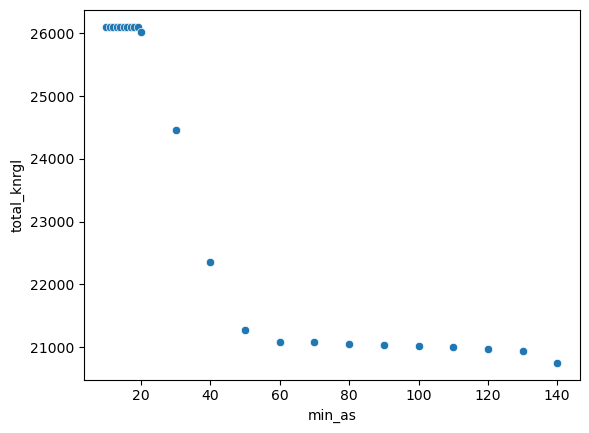

In [29]:
sns.scatterplot(data=res, x="min_as", y="total_knrgl")

In [30]:
res

,total,total_knrgl,primary_proper_pairs,primary_proper_pairs_knrgl,discordant_r1,discordant_r1_knrgl,discordant_r2,discordant_r2_knrgl,split_r1,split_r1_knrgl,split_r2,split_r2_knrgl,unmapped_clipped_r1,unmapped_clipped_r2,min_as
0,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,10
14,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,11
15,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,12
16,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,13
17,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,14
18,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,15
19,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,16
20,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,17
21,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,18
22,4262538,26102,3056701,12204,322330,9173,322330,280,215184,5154,563012,7176,0,0,19


**Conclusion:** use `-T 19`, since it's the highest value before `total_knrgl` begins to drop